In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [46]:
# Cargar el archivo CSV
df = pd.read_csv("Housing.csv")

In [47]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [48]:
# Convertir variables categóricas binarias en 0 y 1
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=['furnishingstatus'], prefix=['furnishingstatus'])
for column in ['furnishingstatus_furnished', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']:
    df[column] = df[column].astype(int)



In [49]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0


In [50]:
# Crear características adicionales
df['area_bedrooms'] = df['area'] * df['bedrooms']
df['bathrooms_stories'] = df['bathrooms'] * df['stories']
df['area_parking_ratio'] = df['area'] / (df['parking'] + 1)  # Evita división por cero
df['bedrooms_bathrooms_ratio'] = df['bedrooms'] / (df['bathrooms'] + 1)
df['area_squared'] = df['area'] ** 2
df['mainroad_prefarea'] = (df['mainroad'] & df['prefarea']).astype(int)
df['hvac_status'] = df['hotwaterheating'] + 2 * df['airconditioning']
df['bedrooms_bathrooms_stories'] = df['bedrooms'] * df['bathrooms'] * df['stories']
df['area_per_bedroom'] = df['area'] / (df['bedrooms'] + 1)
df['area_per_bathroom'] = df['area'] / (df['bathrooms'] + 1)
df['bedrooms_squared'] = df['bedrooms'] ** 2
df['bathrooms_squared'] = df['bathrooms'] ** 2
df['stories_squared'] = df['stories'] ** 2

In [51]:
df['hvac_status'] = 0  # Default value: no heating or air conditioning
df.loc[(df['hotwaterheating'] == 1), 'hvac_status'] = 1  # Only heating
df.loc[(df['airconditioning'] == 1), 'hvac_status'] = 2  # Only air conditioning
df.loc[(df['hotwaterheating'] == 1) & (df['airconditioning'] == 1), 'hvac_status'] = 3  # Heating and air conditioning

In [9]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,...,bedrooms_bathrooms_ratio,area_squared,mainroad_prefarea,hvac_status,bedrooms_bathrooms_stories,area_per_bedroom,area_per_bathroom,bedrooms_squared,bathrooms_squared,stories_squared
0,13300000,7420,4,2,3,1,0,0,0,1,...,1.333333,55056400,1,2,24,1484.0,2473.333333,16,4,9
1,12250000,8960,4,4,4,1,0,0,0,1,...,0.800000,80281600,0,2,64,1792.0,1792.000000,16,16,16
2,12250000,9960,3,2,2,1,0,1,0,0,...,1.000000,99201600,1,0,12,2490.0,3320.000000,9,4,4
3,12215000,7500,4,2,2,1,0,1,0,1,...,1.333333,56250000,1,2,16,1500.0,2500.000000,16,4,4
4,11410000,7420,4,1,2,1,1,1,0,1,...,2.000000,55056400,0,2,8,1484.0,3710.000000,16,1,4


In [52]:
# Seleccionar variables numéricas para escalar
features = ['price','area', 'bedrooms', 'bathrooms', 'stories', 'area_bedrooms', 'bathrooms_stories', 'area_parking_ratio',
            'bedrooms_bathrooms_ratio', 'area_squared', 'bedrooms_bathrooms_stories', 'area_per_bedroom',
            'area_per_bathroom', 'bedrooms_squared', 'bathrooms_squared', 'stories_squared','hvac_status']

In [53]:
X = df.drop('price', axis=1)
df['log_price'] = np.log1p(df['price'])  # log(1 + price) evita log(0)

# Definir la variable objetivo con el logaritmo
y = df['log_price']

X = X[[col for col in features if col != 'price']]

In [54]:
# Aumentación de datos
def augment_data(X, y, num_samples=500):
    np.random.seed(42)
    idx1 = np.random.randint(0, len(X), num_samples)
    idx2 = np.random.randint(0, len(X), num_samples)
    alpha = np.random.uniform(0, 1, num_samples).reshape(-1, 1)
    X_aug = alpha * X.iloc[idx1].values + (1 - alpha) * X.iloc[idx2].values
    y_aug = alpha.flatten() * y.iloc[idx1].values + (1 - alpha.flatten()) * y.iloc[idx2].values
    noise_X = np.random.normal(0, 0.01, X_aug.shape)
    noise_y = np.random.normal(0, 0.01, y_aug.shape)
    X_aug += noise_X
    y_aug += noise_y
    return pd.DataFrame(X_aug, columns=X.columns), pd.Series(y_aug, name=y.name)

X_aug, y_aug = augment_data(X, y, num_samples=3500)
X = pd.concat([X, X_aug], axis=0)
y = pd.concat([y, y_aug], axis=0)


In [55]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Crear escaladores
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Ajustar y transformar X
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)  # Usamos transform() en los datos de prueba

# Ajustar y transformar y (reshape para mantener la dimensión correcta)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


In [57]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3236, 16)
(3236,)
(809, 16)
(809,)


In [58]:
# Construir el modelo de red neuronal
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001)),
    Dropout(0.1),

    Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001)),
    Dropout(0.1),

    Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    Dropout(0.1),

    Dense(1, activation='linear')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [61]:
# Configurar Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=20,
                                               restore_best_weights=True)


In [62]:
# Entrenar el modelo
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 1.7702 - mae: 0.6711 - val_loss: 1.3635 - val_mae: 0.5168
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3808 - mae: 0.5323 - val_loss: 1.2371 - val_mae: 0.4928
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2710 - mae: 0.5253 - val_loss: 1.1373 - val_mae: 0.4897
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1563 - mae: 0.5091 - val_loss: 1.0477 - val_mae: 0.4849
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0765 - mae: 0.5079 - val_loss: 0.9805 - val_mae: 0.4912
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9902 - mae: 0.4933 - val_loss: 0.9061 - val_mae: 0.4825
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9348 - mae: 0.5112 - val_loss: 0.8404 - val_mae: 0.4761
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8702 - mae: 0.4989 - val_loss: 0.7884 - val_mae: 0.4774
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.83

In [63]:
# Hacer predicciones con el modelo
y_pred = model.predict(X_test)

# Deshacer la normalización usando el scaler
y_pred_original_scaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Asegúrate de que y_pred sea un arreglo 2D

# Deshacer la transformación logarítmica (restaurar los valores originales)
y_pred_original = np.expm1(y_pred_original_scaled)

# Deshacer la normalización de los valores reales (y_test)
y_test_scaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Asegúrate de que y_test sea un arreglo 2D

# Deshacer la transformación logarítmica de los valores reales
y_test_original = np.expm1(y_test_scaled)

# Calcular las métricas con los valores originales
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

# Calcular los porcentajes de error
avg = np.mean(y_test_original)
rmse_percentage = (rmse / avg) * 100
mae_percentage = (mae / avg) * 100

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [64]:

print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae}")
print(f"RMSE Percentage: {rmse_percentage:.2f}%")
print(f"MAE Percentage: {mae_percentage:.2f}%")


RMSE: 811922.0521299025
R²: 0.7108994796591697
MAE: 614580.3516171895
RMSE Percentage: 17.18%
MAE Percentage: 13.01%


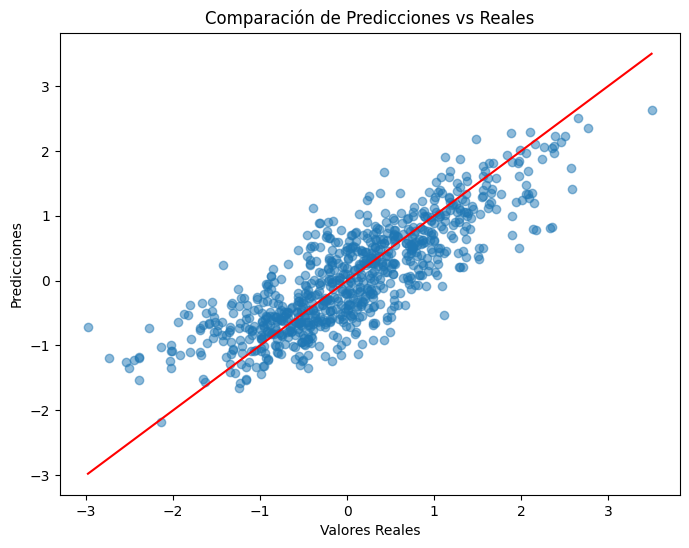

In [65]:
# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Comparación de Predicciones vs Reales")
plt.show()


In [66]:
model.save('house_price_2.h5')  # Guarda en formato HDF5
# O también puedes usar:
model.save('house_price_2.keras')  # Guarda en formato Keras nativo

In [67]:
# Guardar pesos y configuración por separado
model.save_weights('house_price2.weights.h5')  # Guardar los pesos
with open('house_price_config2.json', 'w') as f:
    f.write(model.to_json())  # Guardar la configuración

In [68]:
# Guardar los scalers
import pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)